# **Decision Tree Model (ID3 Algorithm)**

Importing Libraries

In [414]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

Step 1: Loading & Basic cleaning

In [415]:
df = pd.read_csv("DatasetofDiabetes.csv")

# Drop duplicates
df = df.drop_duplicates()
print(f"Rows after dropping duplicates: {df.shape[0]}")

# Numeric features (NOT ID or No_Pation)
numeric_cols = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol',
                'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
feature_cols = numeric_cols + ['Gender']


Rows after dropping duplicates: 1000


Step 2: Outlier Handling (IQR + median)

In [416]:
for col in numeric_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    median_val = df[col].median()
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_count = mask.sum()
    df.loc[mask, col] = median_val
    print(f"{col}: {outlier_count} outliers replaced with median {median_val:.3f}")

AGE: 98 outliers replaced with median 55.000
Urea: 65 outliers replaced with median 4.600
Cr: 52 outliers replaced with median 60.000
HbA1c: 6 outliers replaced with median 8.000
Chol: 27 outliers replaced with median 4.800
TG: 55 outliers replaced with median 2.000
HDL: 50 outliers replaced with median 1.100
LDL: 11 outliers replaced with median 2.500
VLDL: 74 outliers replaced with median 0.900
BMI: 3 outliers replaced with median 30.000


Step 3: Target (Class) Preprocessing:  N,P,Y  →  0,1,2

In [417]:
df['CLASS'] = df['CLASS'].astype(str).str.strip().str.upper()
label_map = {'N': 0, 'P': 1, 'Y': 2}
y = df['CLASS'].map(label_map)
y = y.astype(int)

print("Class counts:")
print(y.value_counts())

Class counts:
CLASS
2    844
0    103
1     53
Name: count, dtype: int64


Step 4: Gender Preprocessing: M,F  →  1,0

In [418]:
df['Gender'] = df['Gender'].astype(str).str.strip().str.upper()
df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})

print(df['Gender'].value_counts(dropna=False))

Gender
1    565
0    435
Name: count, dtype: int64


Step 5: Feature Importance (Correlation with Class)

In [419]:
df_corr = df.copy()
df_corr['CLASS_NUM'] = y  # numeric target

corr = df_corr[numeric_cols + ['CLASS_NUM']].corr()
feat_corr = corr['CLASS_NUM'].sort_values(ascending=False)
print(feat_corr)

CLASS_NUM    1.000000
BMI          0.576713
HbA1c        0.535989
AGE          0.409657
TG           0.227809
VLDL         0.199177
Chol         0.172869
Urea         0.075775
Cr           0.020217
HDL          0.013369
LDL         -0.016643
Name: CLASS_NUM, dtype: float64


Step 6: Discretization of numeric features using scientific ranges

In [420]:

def apply_scientific_discretization(df):
    df = df.copy()

    # AGE
    df['AGE_bin'] = pd.cut(
        df['AGE'],
        bins=[0, 20, 35, 50, 65, 200],
        labels=['adolescent', 'young_adult', 'mid_age', 'senior', 'elderly']
    )

    # Urea
    df['Urea_bin'] = pd.cut(
        df['Urea'],
        bins=[0, 2.5, 7.1, 15, 100],
        labels=['low', 'normal', 'high', 'critical']
    )

    # Creatinine
    df['Cr_bin'] = pd.cut(
        df['Cr'],
        bins=[0, 50, 80, 120, 1000],
        labels=['low', 'normal', 'high', 'critical']
    )

    # HbA1c
    df['HbA1c_bin'] = pd.cut(
        df['HbA1c'],
        bins=[0, 5.7, 6.4, 20],
        labels=['normal', 'prediabetes', 'diabetes']
    )

    # Cholesterol
    df['Chol_bin'] = pd.cut(
        df['Chol'],
        bins=[0, 5.2, 6.2, 20],
        labels=['desirable', 'borderline', 'high']
    )

    # Triglycerides
    df['TG_bin'] = pd.cut(
        df['TG'],
        bins=[0, 1.7, 2.2, 20],
        labels=['normal', 'borderline', 'high']
    )

    # HDL
    df['HDL_bin'] = pd.cut(
        df['HDL'],
        bins=[0, 1.0, 1.5, 20],
        labels=['low', 'normal', 'protective']
    )

    # LDL
    df['LDL_bin'] = pd.cut(
        df['LDL'],
        bins=[0, 2.6, 3.3, 4.1, 20],
        labels=['optimal', 'near_optimal', 'borderline', 'high']
    )

    # VLDL
    df['VLDL_bin'] = pd.cut(
        df['VLDL'],
        bins=[0, 0.5, 1.0, 2.0, 100],
        labels=['low', 'normal', 'elevated', 'high']
    )

    # BMI
    df['BMI_bin'] = pd.cut(
        df['BMI'],
        bins=[0, 18.5, 25, 30, 35, 40, 200],
        labels=['underweight', 'normal', 'overweight', 'obese_I', 'obese_II', 'obese_III']
    )

    return df

df_discrete = apply_scientific_discretization(df)
df_discrete = df_discrete.dropna()
df_discrete


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,...,AGE_bin,Urea_bin,Cr_bin,HbA1c_bin,Chol_bin,TG_bin,HDL_bin,LDL_bin,VLDL_bin,BMI_bin
0,502,17975,0,50,4.7,46,4.9,4.2,0.9,1.1,...,mid_age,normal,low,normal,desirable,normal,normal,optimal,low,normal
1,735,34221,1,55,4.5,62,4.9,3.7,1.4,1.1,...,senior,normal,normal,normal,desirable,normal,normal,optimal,normal,normal
2,420,47975,0,50,4.7,46,4.9,4.2,0.9,1.1,...,mid_age,normal,low,normal,desirable,normal,normal,optimal,low,normal
3,680,87656,0,50,4.7,46,4.9,4.2,0.9,1.1,...,mid_age,normal,low,normal,desirable,normal,normal,optimal,low,normal
4,504,34223,1,55,7.1,46,4.9,4.9,1.0,0.8,...,senior,normal,low,normal,desirable,normal,low,optimal,low,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200,454317,1,71,4.6,97,7.0,7.5,1.7,1.2,...,elderly,normal,high,diabetes,high,normal,normal,optimal,normal,overweight
996,671,876534,1,55,3.0,60,12.3,4.1,2.2,0.7,...,senior,normal,normal,diabetes,desirable,borderline,low,optimal,normal,obese_II
997,669,87654,1,55,7.1,81,6.7,4.1,1.1,1.2,...,senior,normal,high,diabetes,desirable,normal,normal,optimal,normal,overweight
998,99,24004,1,55,5.8,59,6.7,5.3,2.0,1.6,...,senior,normal,normal,diabetes,borderline,borderline,protective,near_optimal,normal,obese_III


Step 7: Encoding new discrete columns

In [421]:
df_enc = df_discrete.copy()
encoders = {}

categorical_columns = [
    'AGE_bin','Urea_bin','Cr_bin','HbA1c_bin','Chol_bin','TG_bin',
    'HDL_bin','LDL_bin','VLDL_bin','BMI_bin','Gender','CLASS'
]

for col in categorical_columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le



Step 8: Feature Selection

In [422]:
X = df_enc[
    ['AGE_bin','Urea_bin','Cr_bin','HbA1c_bin','Chol_bin',
     'TG_bin','HDL_bin','LDL_bin','VLDL_bin','BMI_bin']
]

y = df_enc['CLASS']

Step 9: Train/Test split

In [423]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nData sizes:")
print("Training:", len(X_train))
print("Testing :", len(X_test))


Data sizes:
Training: 800
Testing : 200


Step 10: Training and Evaluating

In [424]:
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    random_state=42
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [425]:
print("Accuracy:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=["Actual 0", "Actual 1", "Actual 2"],
                     columns=["Pred 0", "Pred 1", "Pred 2"])
print("\nConfusion Matrix:")
print(cm_df)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoders['CLASS'].classes_))

print("Train vs Test Accuracies")
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(train_acc, test_acc)


from sklearn.model_selection import cross_val_score
print("\nCross Validation folds:")
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Mean Accuracy:", scores.mean())



Accuracy: 0.955

Confusion Matrix:
          Pred 0  Pred 1  Pred 2
Actual 0      20       0       1
Actual 1       1       5       0
Actual 2       7       0     166

Classification Report:
              precision    recall  f1-score   support

           N       0.71      0.95      0.82        21
           P       1.00      0.83      0.91         6
           Y       0.99      0.96      0.98       173

    accuracy                           0.95       200
   macro avg       0.90      0.92      0.90       200
weighted avg       0.96      0.95      0.96       200

Train vs Test Accuracies
0.96125 0.955

Cross Validation folds:
[0.825 0.98  0.995 0.95  0.92 ]
Mean Accuracy: 0.9339999999999999


Plot

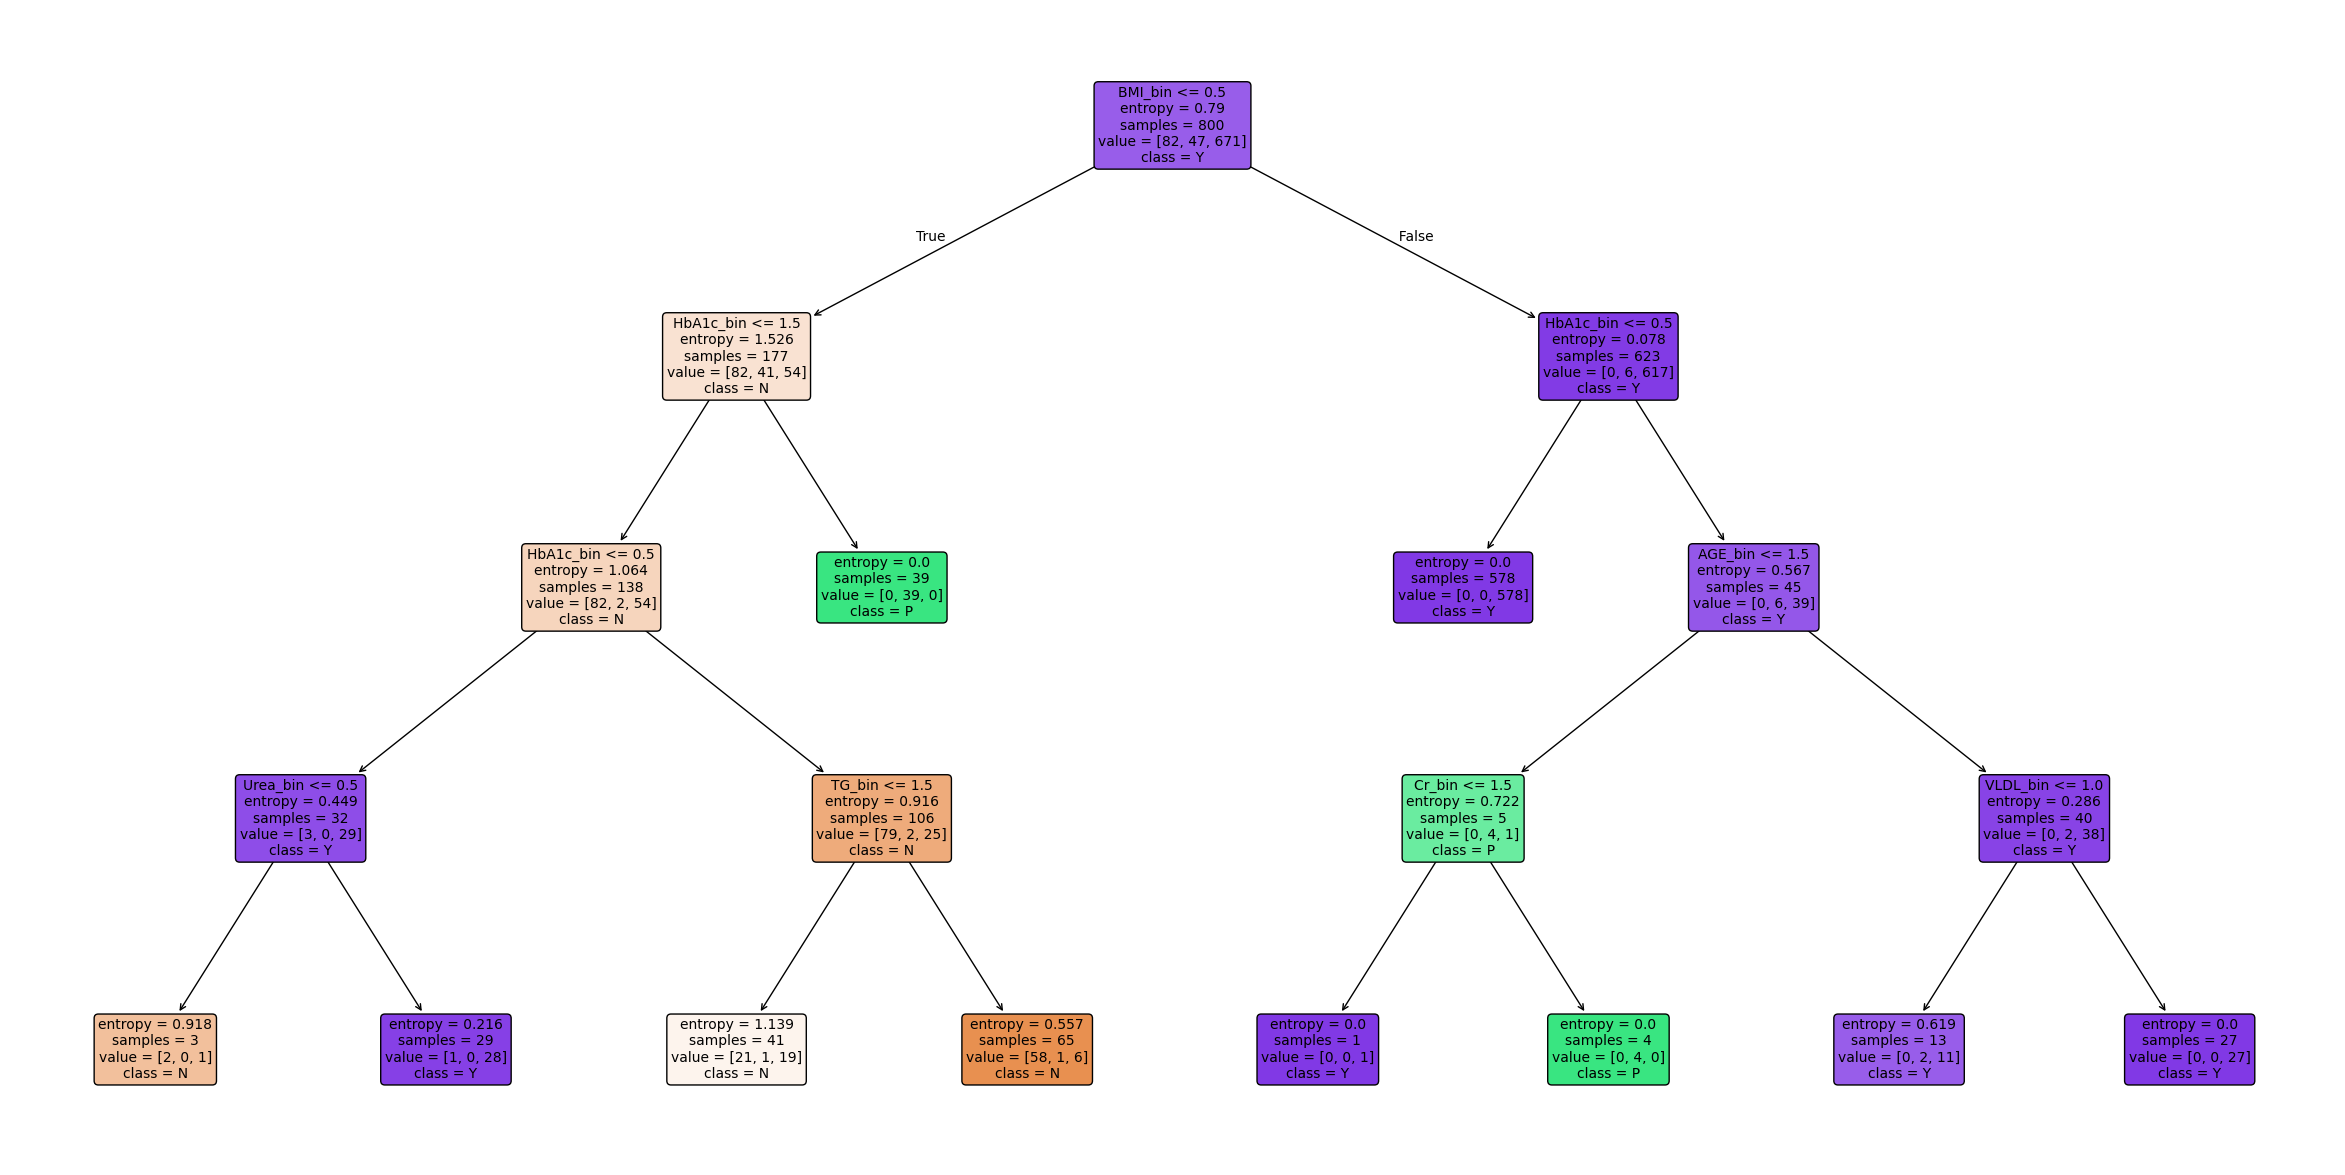

In [426]:

plt.figure(figsize=(30, 15))
plot_tree(
    clf,
    feature_names=X_train.columns,
    class_names=['N', 'P', 'Y'],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()
